# PHYS20762 Project 3: Monte Carlo Techniques

## Neutron Transport and Scattering Through a Shielding Layer

Author: Ella Beck<br>
April 2023

In this project, the Monte Carlo method is used to develop a simulation of thermal neutrons travelling through a set thickness of material. The Monte Carlo method is a method used to simulate events (and therefore predict the probability of certain outcomes) where a random process is involved. It is therefore useful for modelling processes in nuclear physics, since probabilities that certain nuclear events will happen (e.g. an isotope decaying, a neutron being absorbed upon collision with a nucleus) are random. The method can provide accurate results for systems of high complexity, such as systems with very large numbers of particles.

When thermal neutrons travel through a layer of material, they will collide with the nuclei in the material. Depending on the energy of the neutron when this collision occurs, the neutron may be absorbed by the nucleus. The probability that a neutron will be absorbed is also dependent on the composition of the material: denser materials will absorb more particles as they have a higher concentration of nuclei (and therefore each neutron will experience a larger number of collisions). Rates of absorption for neutrons travelling through a given material will also change as the thickness of the material varies. The rate of absorption of neutrons travelling through a given thickness of a certain material can therefore be difficult to model using traditional methods.

Generating true randomly distributed numbers is crucial to obtaining accurate simulations using the Monte Carlo method. Random numbers are used in this Monte Carlo simulation to model the inherently random behaviour of particles, and so any bias in the random number generator will skew the final results. Throughout this project, care is taken to ensure that true random numbers are generated and that there is no correlation between the behaviour of any neutrons.

In this project, a random number generator is used to produce sets of isotropic vectors. The length of these vectors are distributed exponentially, and these vectors are used to model the distance a neutron will travel through a given thickness of material without a collision. The Monte Carlo method is then used to simulate a random walk of neutrons through the material, as well as calculate the probability that a neutron will be reflected, absorbed, or transmitted. The variation of transmission rate with material thickness is then explored, and this data is used to estimate the attenuation length of water, lead, and graphite. Finally, the Woodcock method is used to predict the probability of transmission of a neutron through slabs of two different materials.

------------------------------------------------------------------------------

Initialisation: importing libraries and defining global constants

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#import pandas as pd
import concurrent.futures
from scipy.optimize import curve_fit
#import warnings

#warnings.simplefilter('ignore', DeprecationWarning)

In [2]:
avogadro_const = 6.022 * (10**23)

water_absorption_coeff = 6.652 * (10 ** (-25))#cm^2
water_scattering_coeff = 1.03 * (10 ** (-22))#cm^2
water_density = 1#g/cm^3
water_molar_mass = 18.0153#g/mol

lead_absorption_coeff = 1.58 * (10 ** (-25))#cm^2
lead_scattering_coeff = 1.1221 * (10 ** (-23))#cm^2
lead_density = 11.35#g/cm^3
lead_molar_mass = 207.2#g/mol

graphite_absorption_coeff = 4.5 * (10 ** (-27))#cm^2
graphite_scattering_coeff = 4.74 * (10 ** (-24))#cm^2
graphite_density = 1.67#g/cm^3
graphite_molar_mass = 12.011#g/mol

## Checking the accuracy of 'numpy.random.uniform()'

Initially we want to check that 'numpy.random.uniform()' produces a uniform distribution. We will do this by using 'numpy.random.uniform()' to generate a fixed number of points between -1 and 1, and plot these points in a histogram in order to visually check their uniformity. We will then find the mean of the points generated: a truly uniform distribution will have a mean value of zero. We will repeat this test for several numbers of points.

The mean of the values for n = 100 points is -0.005350404984836457
The mean of the values for n = 1000 points is 0.025188078287935376
The mean of the values for n = 10000 points is 0.004608821332350183
The mean of the values for n = 100000 points is 0.0013123967860471345


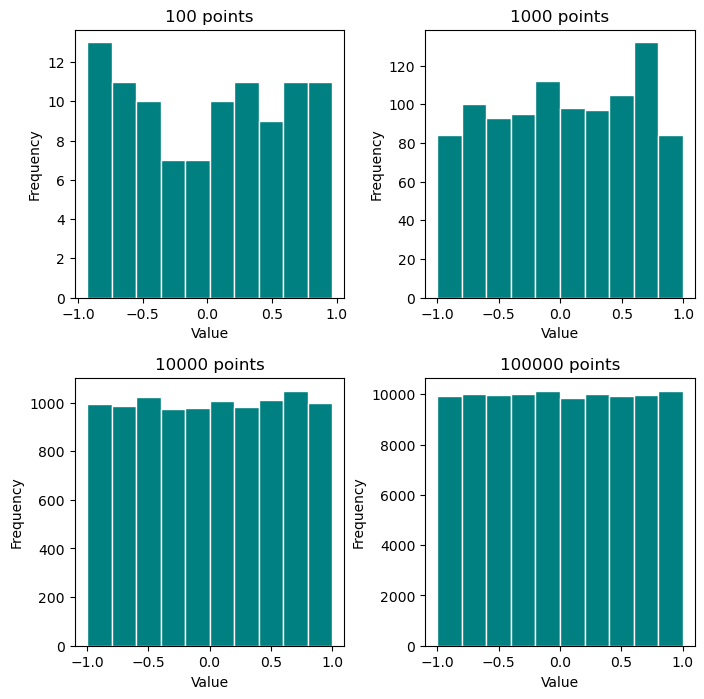

In [3]:
%matplotlib inline
number_of_points_to_test = [100, 1000, 10000, 100000]
histograms_fig = plt.figure(figsize = [8, 8])
uniform_distribution_subplot_grid = gridspec.GridSpec(2, 2, wspace = 0.3, hspace = 0.3)

def generate_random_uniform_points_one_dimension(number_of_points):
    """
    Generates a 2D array of random uniformly distributed points between the values of -1 and 1 using numpy.random.uniform.
    The size of the array in each dimension is given by the 'number_of_points' variable.
    
    Parameters
    ----------
    number_of_points : float
        A parameter defining how big the 2D array should be. For example, if number_of_points = 10, the output will be a 
        10 x 10 array.
        
    Returns
    -------
    points: array
        A 2D array of uniform randomly distributed points. The size of this array is given by number_of_points.
    """
    
    points = np.random.uniform(low = -1.0, high = 1.0, size = (number_of_points))
    
    return points

for i in range(4):
    #create a flat 1D array of randomly generated points
    test_points = generate_random_uniform_points_one_dimension(number_of_points_to_test[i])
    test_points_array = test_points.flatten()
    
    #plotting the distribution of these points
    ax = histograms_fig.add_subplot(uniform_distribution_subplot_grid[i])
    ax.hist(test_points_array, color = 'teal', edgecolor = 'white')
    ax.set_title('{0} points'.format(number_of_points_to_test[i]))
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')
    
    #finding the mean of the points
    mean = np.mean(test_points_array)
    print('The mean of the values for n = {0} points is {1}'.format(number_of_points_to_test[i], mean))

plt.show()

It can be seen from these results that as the number of points increases, the uniformity of the values produced by 'numpy.random.uniform' increases.

## Generating random uniformly distributed points in 3D

We will now use 'np.random.uniform()' to generate randomly distributed points in 3D, and perform a spectral test to check that these points are uncorrelated.

<IPython.core.display.Javascript object>


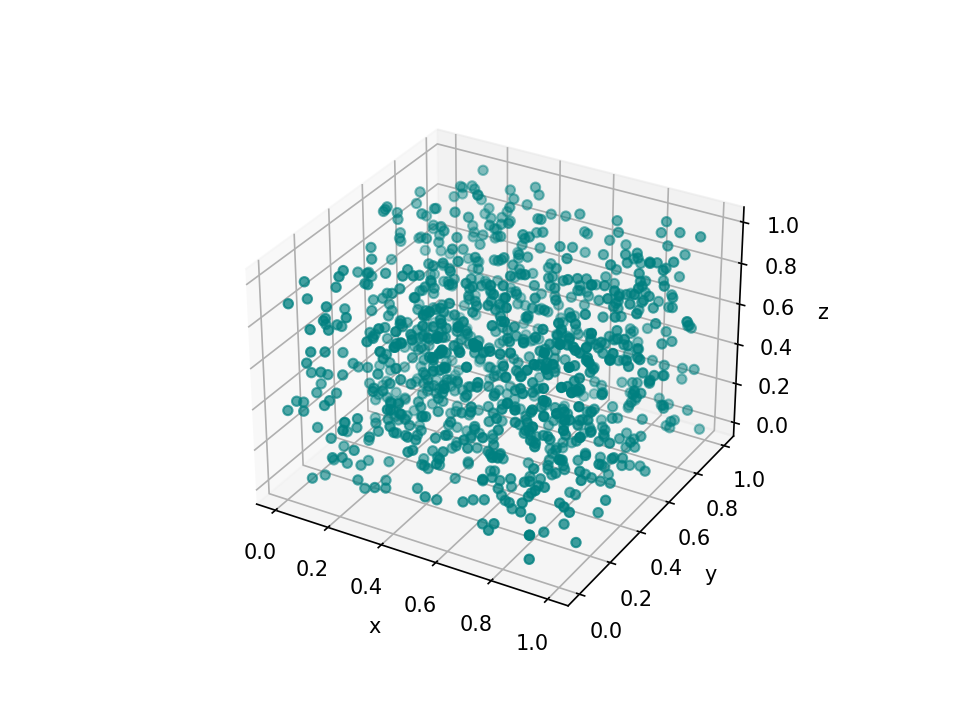

In [5]:
#%matplotlib inline
#get_ipython().magic('matplotlib notebook')
#fig = plt.figure()
%matplotlib notebook
# %matplotlib notebook

def generate_random_uniform_points_three_dimensions(number_of_points):
    """
    Generates a 2D array of random uniformly distributed points between the values of 0 and 1 using numpy.random.uniform.
    The size of the array in each dimension is given by the number_of_points parameter.
    
    Parameters
    ----------
    number_of_points : float
        A parameter defining how big the 2D array should be. For example, if number_of_points = 10, the output will be a 
        10 x 10 array.
        
    Returns
    -------
    points: array
        A 2D array of uniform randomly distributed points. The size of this array is given by number_of_points.
    """
    
    xpoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    ypoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    zpoints = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    
    return xpoints, ypoints, zpoints

fig = plt.figure()
euclidean_space_xpoints, euclidean_space_ypoints, euclidean_space_zpoints = \
    generate_random_uniform_points_three_dimensions(1000)

euclidean_space_graph = fig.add_subplot(111, projection = '3d')
euclidean_space_graph.scatter(euclidean_space_xpoints, euclidean_space_ypoints, euclidean_space_zpoints, color = 'teal')
euclidean_space_graph.set_xlabel('x')
euclidean_space_graph.set_ylabel('y')
euclidean_space_graph.set_zlabel('z')
plt.show()

It can be seen by examining this plot that there are no hyperplanes present, therefore there are no spectral issues caused by 'np.random.uniform()'. Hyperplanes arise when there are correlations between points.

## Demonstrating spectral issues caused by randssp.ipynb

The 'randssp.ipynb' notebook generates random numbers using the linear conguruential method. This method involves producing a sequence of numbers, given a starting number (known as the seed). The sequence is unbiased but deterministic, and it repeats periodically. However, as a result of Marsaglia's theorem, the points generated by the linear congruential method are correlated and lie on hyperplanes. Therefore there exists regions in 3D space where these points cannot lie, meaning that the distribution of points is not isotropic and therefore points generated by this method cannot be used to model random walks. The 'randssp.ipynb' code is displayed below.

<IPython.core.display.Javascript object>


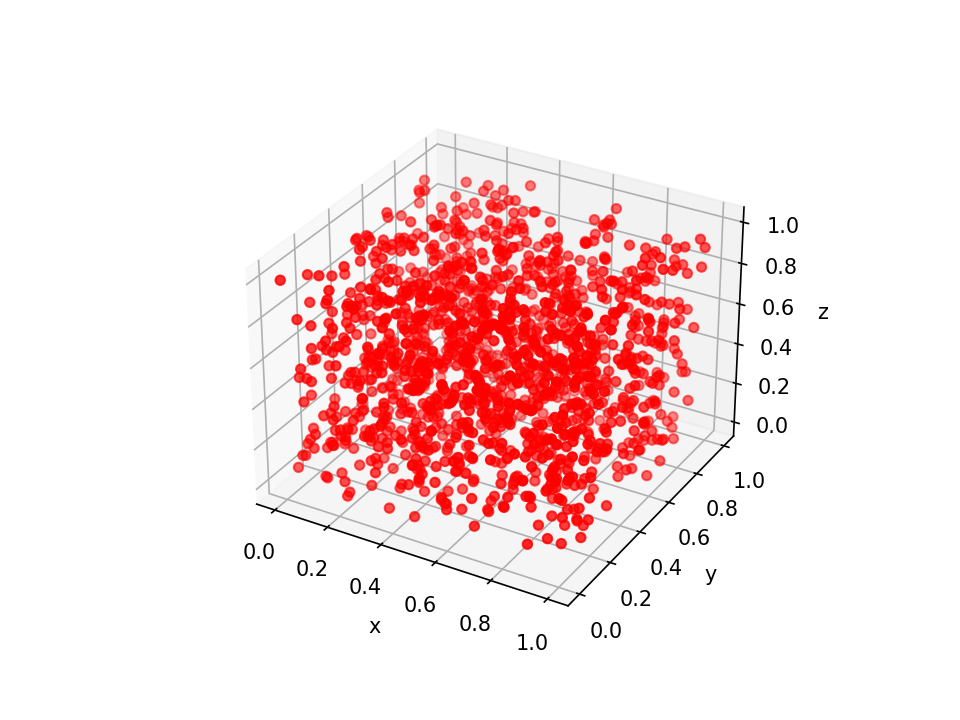

In [6]:
#get_ipython().magic('matplotlib notebook')
#%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

def randssp(p, q):
    """
    Generates a set of random coordinates using the linear congruential method.
    
    Parameters
    ----------
    p : int
        A parameter representing the number of dimensions each coordinate should have.
    q : int
        Determines the amount of points generated.
        
    Returns
    -------
    r: array
        A 3D array of coordinates. 
    """
    global m, a, c, x
        
    try: x
    except NameError:
        m = pow(2, 31)# modulus
        a = pow(2, 16) + 3# multiplier
        c = 0# increment
        x = 123456789# seed
    
    try: p
    except NameError:
        p = 1
    try: q
    except NameError:
        q = p
    
    r = np.zeros([p,q])

    for l in range (0, q):
        for k in range (0, p):
            x = np.mod(a*x + c, m)
            r[k, l] = x/m
    
    return r

#generating coordinates
k = randssp(3, 1500)

#plotting results
ax.scatter(k[0, :], k[1, :], k[2, :], color='r')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

plt.show()

Upon rotating this plot, clear hyperplanes can be seen. This proves that the linear congruential generator produces points that are correlated.

## Modelling an exponential distribution

Here we create a random number generator that produces samples distributed according to an exponential function exp(-x / lambda), where lambda represents the (estimated) mean free path of the material used. This can be used to model the distance a neutron will travel before colliding with a nucleus of a given material. We generate samples a set number of times and plot a histogram of the average distance traveled by each neutron. We perform a linear fit of the natural log of the frequency against the distance travelled; the attenuation length of the given material can then be obtained from the gradient of the resulting graph. We use this code to determine the mean free path of water.

Measured mean free path = (44.9551 ± 0.0028) cm


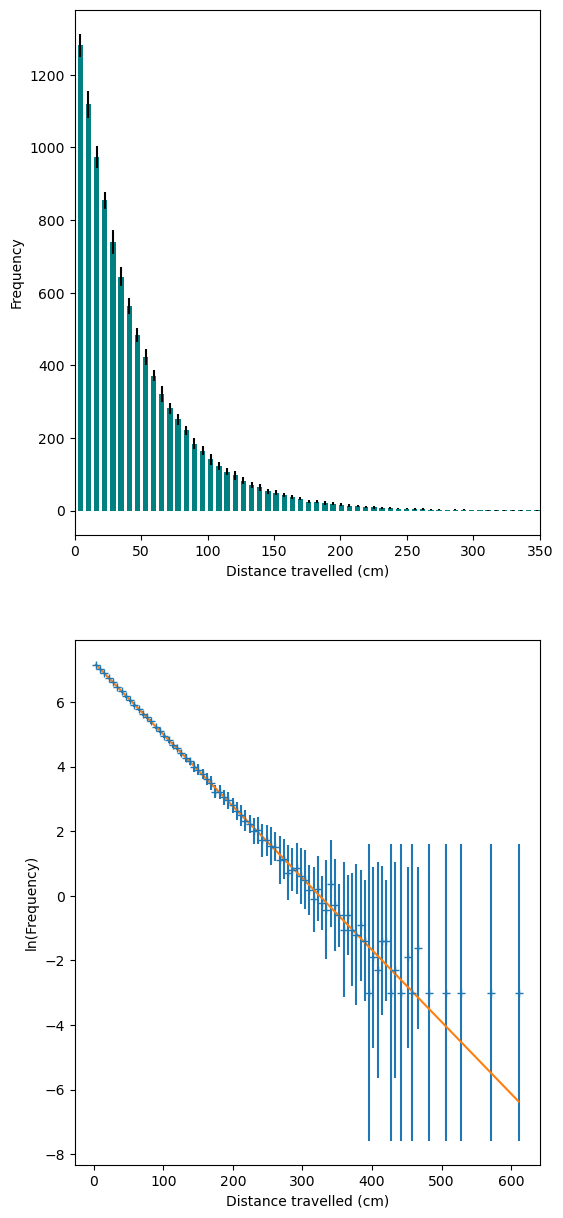

In [7]:
%matplotlib inline
fig = plt.figure(figsize = (6,15))
histogram = fig.add_subplot(211)
logplot = fig.add_subplot(212)


estimated_attenuation_length_water = 1 / 45 #cm

def sampling_exponential_distribution(mean_free_path, number_of_points):
    """
    Generates a set of random numbers which are exponentially distributed.
    
    Parameters
    ----------
    mean_free_path : float
        A parameter representing the mean free path of the samples being
        exponentially distributed.
    number_of_points : int
        Determines the amount of points generated.
        
    Returns
    -------
    exponential_samples: array
        A 2D array of exponential randomly distributed points. 
        The size of this array is given by number_of_points.
    """
    samples = np.random.uniform(low = 0, high = 1.0, size = (number_of_points))
    exponential_samples = (-1 * mean_free_path) * np.log(samples)
    
    return exponential_samples

def generate_histogram(data, min_value, max_value, number_of_bins):
    """
    Generates a histogram based on a set of data.
    
    Parameters
    ----------
    data : array
        An array of data points to be fit into a histogram.
    min_value : float
        Determines the value where the first bin should start.
    max_value : float
        Determines the value where the last bin should end.
    number_of_bins : int
        Determines the number of bins generated.
        
    Returns
    -------
    histogram : array
        An array showing the occupancy of each respective bin.
    bins : array
        An array displaying the values corresponding to the edge of each bin.
    """
    histogram, bins = np.histogram(data, bins = number_of_bins, range = (min_value, max_value))
    return histogram, bins

def linear_function(x, m, c):
    """
    Generates a linear set of data.
    
    Parameters
    ----------
    x : array
        An array of x-values of a line.
    m : float
        Determines the gradient of the line.
    c : float
        Determines the y-intercept of the line.
        
    Returns
    -------
    y : array
        An array of y-values of a line.
    """
    y = (m * x) + c
    return y
    

def generate_histograms(number_of_tests, mean_free_path, number_of_points, number_of_bins):
    """
    For a set number of particles, this function generates the distance travelled by each one, according to a random 
    exponential distibution. Fits the data into a histogram using the 'generate_histogram' function. Generates multiple sets of
    histogram data simultaneously using a thread pool. This function ensures that the bins used in each histogram are identical.
    Returns the mean occupancy of each bin, as well as the standard deviation of the occupancy of each bin. Also returns the 
    raw data points for each histogram, and the boundaries of the bins used.
    
    Parameters
    ----------
    number_of_tests : int
        Determines how many histograms should be generated.
    mean_free_path : float
        Determines the mean free path of the material (used to generate the exponentially distributed distances).
    number_of_points : int
        Represents the number of data points in each histogram.
    number_of_bins : int
        Represents the number of bins in each histogram.
        
    Returns
    -------
    flat_data : array
        A flattened array of data points, detailing the occupancies of each bin for each histogram.
    average_occupancies : array
        An array displaying the average occupancies across each bin.
    std_occupancies : array
        An array displaying the standard deviation of the occupanices across each bin.
    bins : array
        An array showing the edge values of each bin.
    """
    #producing 20 sets of data simultaneously using a thread pool
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(sampling_exponential_distribution, mean_free_path, number_of_points) for i in 
        range(number_of_tests)]
    
    #result gives 2D array of every data point, look for the maximum value and flatten into 1D array (to use in 'plt.hist()'')
    histogram_data = np.array([i.result() for i in data])
    max_value = np.max(histogram_data)
    flat_data = histogram_data.flatten()
    
    #generating occupancies of every bin for each data set
    #note: having the range between 0 and 'max_value' ensures the bins are the same for each data set
    with concurrent.futures.ThreadPoolExecutor() as executor:
        histograms = [executor.submit(generate_histogram, histogram_data[i, :], 0, max_value, number_of_bins) for i in 
        range(number_of_tests)]
    
    #result gives array of bins and occupancies, separating these:
    water_histograms = np.array([i.result() for i in histograms], dtype = object)
    hist = np.dstack(water_histograms[:, 0])[0]
    bins = np.dstack(water_histograms[:, 1])[0][:, 0]#only need to use 1 column as each array of bins is identical
    
    #finding average occupancies for each bin across all data sets
    average_occupancies = np.array([np.sum(hist[i, :] / number_of_tests) for i in range(len(bins) - 1)])
    std_occupancies = np.array([np.std(hist[i, :]) for i in range(len(bins) - 1)])
    
    return flat_data, average_occupancies, std_occupancies, bins

estimated_mean_free_path_water = 1 / estimated_attenuation_length_water
data_points, occupancies, std, bins = generate_histograms(20, estimated_mean_free_path_water, 10000, 100)

#plotting histogram
#histogram.hist(data_points, bins=100, color = 'teal', edgecolor = 'white')
histogram.bar(bins[1:], occupancies, width = -4, align = 'edge', yerr = std, color = 'teal')
histogram.set_xlim((0, 350))
histogram.set_xlabel('Distance travelled (cm)')
histogram.set_ylabel('Frequency')

#plotting log plot
#deleting the empty bins to avoid errors in future calculations
empty_bins = np.where(occupancies == 0)
justified_water_population = np.delete(occupancies, empty_bins)
justified_std = np.delete(std, empty_bins)
justified_bins = np.delete(bins, empty_bins)

#creating an array corresponding to the centre of each bin (to be used in the plot)
bin_centres = np.zeros((len(justified_bins) - 1))
bin_centres = np.array([((justified_bins[i+1] + justified_bins[i]) / 2) for i in range(len(justified_bins) - 1)])

#finding the gradient (and its error) of the data points
population_logs = np.log(justified_water_population)
logplot_parameters, cov = np.polyfit(bin_centres, population_logs, 1, w = (justified_water_population / justified_std), 
                                    cov = True)

#printing data and creating plots
actual_mean_free_path = -1 / logplot_parameters[0]
actual_mean_free_path_error = np.sqrt(cov[0,0]) / logplot_parameters[0]
print(u"Measured mean free path = ({0:.4f} \u00B1 {1:.4f}) cm".format(actual_mean_free_path, 
                                                                      np.abs(actual_mean_free_path_error)))

line_of_best_fit = linear_function(bin_centres, logplot_parameters[0], logplot_parameters[1])
logplot.errorbar(bin_centres, population_logs, (1 / justified_std), fmt = '+')
logplot.plot(bin_centres, line_of_best_fit)
logplot.set_xlabel('Distance travelled (cm)')
logplot.set_ylabel('ln(Frequency)')


plt.show()

It can be seen from this data that the mean free path of water is approximately 45cm, which is consistent with the prediction. From this we can conclude that the exponential samples generated are distributed correctly.

## Producing isotropic unit vectors

We will now use np.random.uniform() to produce isotropic unit vectors that are uniformly distributed over a sphere. This will allow us to generate 3D coordinates that are isotropically distributed for a random walk simulation.

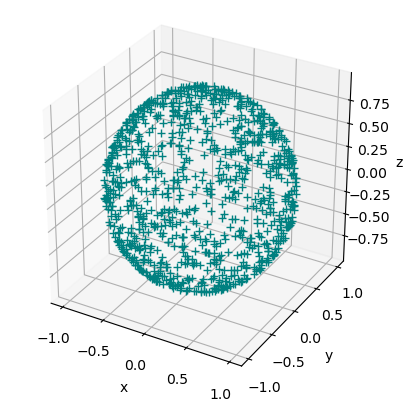

In [8]:
# get_ipython().magic('matplotlib notebook')
# %matplotlib notebook
fig = plt.figure()
unit_vectors_plot = fig.add_subplot(111, projection = '3d')

def produce_unit_vectors(number_of_vectors, magnitude):
    """
    Generates a set number of isotropic vectors of a given magnitude using spherical coordinates.
    
    Parameters
    ----------
    number_of_vectors : int
        Determines the number of unit vectors to be generated.
    magnitude : float
        Determines the length of each unit vector.
        
    Returns
    -------
    x : array
        An array of x-values of each vector.
    y : array
        An array of y-values of each vector.
    z : array
        An array of z-values of each vector.
    vector_magnitude : array
        Returns the magnitude of each vector (used as a test to see output vectors have the correct magnitude).
    theta : array
        Returns an array of polar angles for each vector.
    phi : array
        Returns an array of azimuthal angles for each vector.
    """
    #generating isotropically distributed theta values
    arbitrary_value = np.random.uniform(low = 0, high = 1, size = number_of_vectors)
    theta = np.arccos(1 - (2 * arbitrary_value))#note: using the arccos function here ensures output vectors are isotropic
    
    #generating isotropically distributed phi values
    phi = np.random.uniform(low = 0, high = (2 * np.pi), size = number_of_vectors)
    
    #determining the cartesian coordinates for each vector
    x = magnitude * np.sin(theta) * np.cos(phi)
    y = magnitude * np.sin(theta) * np.sin(phi)
    z = magnitude * np.cos(theta)
    
    #finding the magnitude of each vector
    vector_magnitude = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    
    return x, y, z, vector_magnitude, theta, phi

#generating 1000 isotropic unit vectors
xvalues, yvalues, zvalues, magnitudes, theta, phi = produce_unit_vectors(1000, 1)

#plotting these vectors
unit_vectors_plot.plot(xvalues, yvalues, zvalues, '+', color = 'teal')
unit_vectors_plot.set_box_aspect((1, 1, 1))
unit_vectors_plot.set_xlabel('x')
unit_vectors_plot.set_ylabel('y')
unit_vectors_plot.set_zlabel('z')
plt.show()

Upon examining this plot, it can be seen that the coordinates produced are isotropic and that there are no spectral issues. This confirms that the unit vectors produced are random and uncorrelated.

## Creating isotropic steps

Now we combine the previous 'sampling_exponential_distributon()' and 'produce_unit_vectors()' functions in order to generate isotropic steps with lengths distributed as exp(-x / lambda). These will be the steps used in our random walk simulation, as they model the random distance and direction a neutron will travel without experiencing a collision.

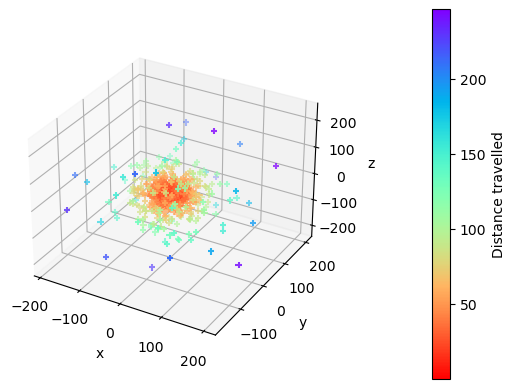

In [9]:
%matplotlib inline
fig = plt.figure()
steps_graph = fig.add_subplot(111, projection = '3d')

def isotropic_steps(mean_free_path, number_of_steps):
    """
    Generates a set number of isotropic steps with lengths distributed according to the exponential function exp(-x / lambda),
    where lambda is the mean free path of a given material.
    
    Parameters
    ----------
    mean_free_path : float
        Corresponds to the mean free path of the given material.
    number_of_steps : int
        Determines the number of isotropic steps generated.
        
    Returns
    -------
    x : array
        An array of x-values of each vector.
    y : array
        An array of y-values of each vector.
    z : array
        An array of z-values of each vector.
    vector_magnitude : array
        Returns the magnitude of each vector.
    theta : array
        Returns an array of polar angles for each vector.
    phi : array
        Returns an array of azimuthal angles for each vector.
    """
    
    #finding the exponentially distributed distances from the 'sampling_exponential_distribution()' function
    distances = sampling_exponential_distribution(mean_free_path, number_of_steps)
    
    #finding the (isotropically distributed) coordinates of each vector from the 'produce_unit_vectors()' function
    x_coordinate, y_coordinate, z_coordinate, magnitudes, theta, phi = produce_unit_vectors(number_of_steps, distances)
    
    return x_coordinate, y_coordinate, z_coordinate, magnitudes, theta, phi

#generating 1000 isotropic steps
x, y, z, magnitudes, theta, phi = isotropic_steps(estimated_mean_free_path_water, 1000)

#plotting each step, color coordinated by distance travelled from the origin
plot = steps_graph.scatter(x, y, z, c = magnitudes, marker = '+', cmap = 'rainbow_r')
steps_graph.set_xlabel('x')
steps_graph.set_ylabel('y')
steps_graph.set_zlabel('z')
cbar = fig.colorbar(plot, pad = 0.2)
cbar.set_label('Distance travelled')
plt.show()

## Random Walk Visualisation

Here we simulate the random walk that 20 neutrons will take inside a 10 cm thickness of water. We use the previous 'isotropic_steps()' function to generate coordinates for each neutron, and check if the neutron has been reflected, absorbed, or scattered after each step. The random walk of each neutron will only continue if it has been scattered inside the material.

C:\Users\ellab\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


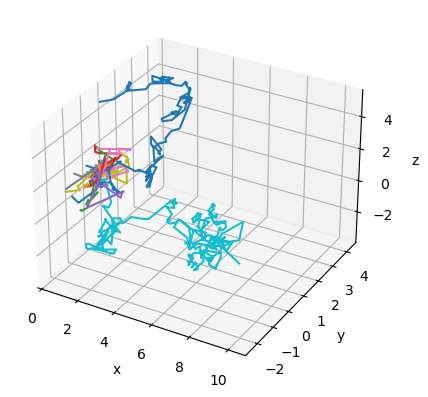

In [28]:
#get_ipython().magic('matplotlib notebook')
%matplotlib inline
fig = plt.figure()
walk_graph = fig.add_subplot(111, projection = '3d')

particles_reflected = 0
particles_absorbed = 0
particles_transmitted = 0

def calculate_parameters(absorption_coeff, scattering_coeff, density, molar_mass):
    """
    Finds the particle density, macroscopic absorption and scattering coefficients, and mean free path of each material from
    the data given.
    
    Parameters
    ----------
    absorption_coeff : float
        Represents the absorption coefficient of the given material.
    scattering_coeff : float
        Represents the scattering coefficient of the given material.
    density : float
        Represents the density of the given material.
    molar_mass : float
        Represents the molar mass of the given material.
        
    Returns
    -------
    particle_density : float
        Represents the particle density of the given material.
    absorption_coeff : float
        Represents the macroscopic absorption cross-section of the given material.
    scattering_coeff : float
        Represents the macroscopic scattering cross-section of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    """
    particle_density = density * avogadro_const / molar_mass
    
    macroscopic_absorption_coeff = particle_density * absorption_coeff
    macroscopic_scattering_coeff = particle_density * scattering_coeff
    
    mean_free_path = 1 / ((particle_density * absorption_coeff) + (particle_density * scattering_coeff))
    
    return particle_density, macroscopic_absorption_coeff, macroscopic_scattering_coeff, mean_free_path


def random_walk_data(thickness, mean_free_path, absorption_probability):
    """
    Finds the coordinates of a particle at each stage of a random walk through a material, given the thickness, mean free path,
    and absorption probability of the material.
    
    Parameters
    ----------
    thickness : float
        Represents the thickness of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    random_walk[:, 0] : array
        Represents the x-coordinates of the particle at each stage of the random walk.
    random_walk[:, 1] : array
        Represents the y-coordinates of the particle at each stage of the random walk.
    random_walk[:, 2] : array
        Represents the z-coordinates of the particle at each stage of the random walk.
    """
    global particles_reflected, particles_absorbed, particles_transmitted
    
    #setting initial coordinates of the particle
    initial_x = -1 * mean_free_path * np.log(np.random.uniform(size = 1))
    initial_coordinates = [initial_x, float(np.random.uniform(size = 1)), float(np.random.uniform(size = 1))]
    random_walk = np.reshape(initial_coordinates, (1,3))
    
    #starting the random walk
    while 0 <= random_walk[-1][0] <= thickness:
        
        #finds new coordinates of the particle using the 'isotropic_steps()' function
        x, y, z, magnitude, theta, phi = isotropic_steps(mean_free_path, 1)
        new_x = random_walk[-1][0] + x
        new_y = random_walk[-1][1] + y
        new_z = random_walk[-1][2] + z
            
        new_coordinates = np.array([float(new_x), float(new_y), float(new_z)])
        
        #generating a random number: if less than the absorption probability of the material then the particle will be absorbed
        random_number = np.random.uniform(size = 1)
        
        if random_number < absorption_probability:
            
            particles_absorbed += 1

            #stopping the random walk if the particle is absorbed
            return random_walk
            
        else:
            #appending the new coordinates to the particle if it is scattered (i.e. not absorbed and inside the material)
            random_walk = np.vstack((random_walk, new_coordinates))
    
    if random_walk[-1][0] < 0:
        particles_reflected += 1
        
    if random_walk[-1][0] > thickness:
        particles_transmitted += 1
                
    return random_walk[:, 0], random_walk[:, 1], random_walk[:, 2]

def random_walk_visualisation(number_of_walks, thickness, mean_free_path, absorption_probability):
    """
    Generates the random walk coordinates for many particles simultaneously using a thread pool.
    
    Parameters
    ----------
    number_of_walks: int
        Represents the number of random walks to be generated
    thickness : float
        Represents the thickness of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    random_walks : array
        Represents the coordinates of each particle as it undergoes a random walk.
    particles_reflected :  int
        Represents the total number of particles reflected back out from the material.
    particles_absorbed :  int
        Represents the total number of particles absorbed into the material.
    particles_transmitted :  int
        Represents the total number of particles transmitted out of the material.
    """
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(random_walk_data, thickness, mean_free_path, absorption_probability) for i in 
        range(number_of_walks)]
    

    random_walks = [i.result() for i in data]

    return random_walks, particles_reflected, particles_absorbed, particles_transmitted

#finding the macroscopic absorption and scattering coefficients, as well as the mean free path of each material
particle_density_water, macroscopic_absorption_coeff_water, macroscopic_scattering_coeff_water, mean_free_path_water = \
calculate_parameters(water_absorption_coeff, water_scattering_coeff, water_density, water_molar_mass)

particle_density_lead, macroscopic_absorption_coeff_lead, macroscopic_scattering_coeff_lead, mean_free_path_lead = \
calculate_parameters(lead_absorption_coeff, lead_scattering_coeff, lead_density, lead_molar_mass)

particle_density_graphite, macroscopic_absorption_coeff_graphite, macroscopic_scattering_coeff_graphite,\
mean_free_path_graphite = calculate_parameters(graphite_absorption_coeff, graphite_scattering_coeff, graphite_density, 
graphite_molar_mass)

#finding the absorption probability of each material
absorption_probability_water = macroscopic_absorption_coeff_water / (macroscopic_absorption_coeff_water + \
    macroscopic_scattering_coeff_water)
absorption_probability_lead = macroscopic_absorption_coeff_lead / (macroscopic_absorption_coeff_lead + \
    macroscopic_scattering_coeff_lead)
absorption_probability_graphite = macroscopic_absorption_coeff_graphite / (macroscopic_absorption_coeff_graphite + \
    macroscopic_scattering_coeff_graphite)

while True:
    try:
        particles_reflected = 0
        particles_absorbed = 0
        particles_transmitted = 0
        
        #generating the random walk of 20 particles
        test = random_walk_visualisation(20, 10, mean_free_path_water, absorption_probability_water)

        #plotting these results
        for i in range(20):
            xvals = test[0][i][0]
            yvals = test[0][i][1]
            zvals = test[0][i][2]
            walk_graph.plot(xvals, yvals, zvals)
    
        break

    except IndexError:
        pass
"""
Note: A try/except loop has been used above as an index error is caused when a particle is immediately reflected (as there
is no corresponding random walk to plot!). If this error is encountered, the 'while' statement will generate 20 more random
walks until no particles are immediately reflected and all particles can be plotted without causing an error.
"""
#plotting a graph
walk_graph.set_xlim(0)
walk_graph.set_xlabel('x')
walk_graph.set_ylabel('y')
walk_graph.set_zlabel('z')
plt.show()


## Generating statistics over lots of random walks

Now we generate the random walk for 10000 neutrons, and count how many were scattered back out of the slab, absorbed into one of the nuclei in the slab, or transmitted through the slab. Note that the y- and z- coordinates are being ignored here, as we assume the slab is 10 cm thick in the x-direction and infinitely thick in the other two directions. We will repeat this process 10 times, and find the average number of neutrons absorbed, transmitted, and reflected. We implement this for 10 cm slabs of water, lead, and graphite in order to obtain the transmission rate for each material.

In [29]:
%matplotlib inline

def random_walk_statistics(number_of_particles, thickness, mean_free_path, absorption_probability):
    """
    Generates a random walk for a set number of particles, and counts the total number of particles absorbed, transmitted, 
    and reflected. Does not generate the coordinates of each particle.
    
    Parameters
    ----------
    number_of_particles: int
        Represents the number of random walks to be generated.
    thickness : float
        Represents the thickness of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    number_reflected :  int
        Represents the total number of particles reflected back out from the material.
    number_absorbed :  int
        Represents the total number of particles absorbed into the material.
    number_transmitted :  int
        Represents the total number of particles transmitted out of the material.
    """
    number_reflected = 0
    number_absorbed = 0
    number_transmitted = 0
    
    #sets the initial x-coordinate (note: y and z coordinates ignored throughout this function)
    x_coordinate = -1 * mean_free_path * np.log(np.random.uniform(size = number_of_particles))
    
    while(len(x_coordinate) > 0):
        
        #finding the number of particles reflectedf and transmitted
        number_reflected += np.count_nonzero(x_coordinate < 0)
        reflected_positions = np.where(x_coordinate < 0)
        
        number_transmitted += np.count_nonzero(x_coordinate > thickness)
        transmitted_positions = np.where(x_coordinate > thickness)
        
        #finding the number of particles absorbed
        random_number = np.random.uniform(size = len(x_coordinate))
        number_absorbed += np.count_nonzero(random_number < absorption_probability)
        absorbed_positions = np.where(random_number < absorption_probability)
        
        #deleting the coordinates of the particles that have been reflected, absorbed, or transmitted
        coordinates_to_delete = np.hstack((reflected_positions, transmitted_positions, absorbed_positions))
        x_coordinate = np.delete(x_coordinate, coordinates_to_delete)
        
        #adding an isotropic step to each remaining x-coordinate
        x_coordinate += isotropic_steps(mean_free_path, len(x_coordinate))[0]
        
    return number_reflected, number_absorbed, number_transmitted

def many_random_walk_statistics(number_of_runs, number_of_particles, thickness, mean_free_path, absorption_probability):
    """
    Repeats a random walk for a set number of particles many times using a thread pool. Finds the mean particles absorbed,
    transmitted, and reflected, as well as the standard deviation of these values. Returns the mean number of particles 
    reflected, absorbed, and transmitted, and the associated error on these.
    
    Parameters
    ----------
    number_of_runs : int
        Represents the number of times the random walks should be generated
    number_of_particles: int
        Represents the number of random walks to be generated.
    thickness : float
        Represents the thickness of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    mean_reflected :  float
        Represents the mean number of particles reflected back out from the material.
    reflected_error : float
        Represents the error on the number of reflected particles.
    mean_absorbed :  float
        Represents the mean number of particles absorbed into the material.
    absorbed_error : float
        Represents the error on the number of absorbed particles.
    mean_transmitted :  float
        Represents the mean number of particles transmitted out of the material.
    transmitted_error : float
        Represents the error on the number of transmitted particles.
    """
    
    #generates sets of random walks using a thread pool
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(random_walk_statistics, number_of_particles, thickness, mean_free_path, 
                absorption_probability) for i in range(number_of_runs)]
        
    total_reflected = 0
    total_absorbed = 0
    total_transmitted = 0
    
    #finding the total number of particles reflected, absorbed, and transmitted from each data set
    random_walks_statistics = np.array([i.result() for i in data])
    reflected = random_walks_statistics[:,0]
    absorbed = random_walks_statistics[:,1]
    transmitted = random_walks_statistics[:,2]
    
    #finding the mean and error on these values
    mean_reflected = np.mean(reflected)
    reflected_error = np.std(reflected) / mean_reflected
    mean_absorbed = np.mean(absorbed)
    absorbed_error = np.std(absorbed) / mean_absorbed
    mean_transmitted = np.mean(transmitted)
    transmitted_error = np.std(transmitted) / mean_transmitted
    
    return mean_reflected, reflected_error, mean_absorbed, absorbed_error, mean_transmitted, transmitted_error

def produce_results_statement(material_name, number_of_runs, number_of_walks, thickness, mean_free_path,
                              absorption_probability):
    """
    Uses the 'many_random_walk_statistics()' function to find the mean number of neutrons reflected, absorbed, and transmitted
    through a set thickness of a given material, and the associated error on these values. Produces a results statement 
    displaying this data.
    
    Parameters
    ----------
    material_name : string
        The name of the material from which the slab is made.
    number_of_runs : int
        Represents the number of times the random walks should be generated
    number_of_particles: int
        Represents the number of random walks to be generated.
    thickness : float
        Represents the thickness of the given material.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
    """
    global particles_reflected, particles_absorbed, particles_transmitted
    particles_reflected = 0
    particles_absorbed = 0
    particles_transmitted = 0
    
    rates = many_random_walk_statistics(number_of_runs, number_of_walks, thickness, mean_free_path, absorption_probability)
    
    print('------------------------------------------------')
    print("Transmission Through A Fixed Thickness: {0}".format(material_name))
    print('------------------------------------------------')
    print("Total Neutrons = {0}".format((number_of_runs * number_of_walks)))
    print("Neutrons Reflected = {0} \u00B1 {1}".format(int(rates[0] * 10), round(rates[1] * 10)))
    print("Neutrons Absorbed = {0} \u00B1 {1}".format(int(rates[2] * 10), round(rates[3] * 10)))
    print("Neutrons Transmitted = {0} \u00B1 {1}".format(int(rates[4] * 10), round(rates[5] * 10)))
    print("Percentage Transmitted = ({0:.3f} \u00B1 {1:.3f}) %".format((rates[4] / 100), (rates[5] / 100)))
    
    return None

#producing results statements for water, lead, and graphite
produce_results_statement("Water", 10, 1000, 10, mean_free_path_water, absorption_probability_water)
produce_results_statement("Lead", 10, 1000, 10, mean_free_path_lead, absorption_probability_lead)
produce_results_statement("Graphite", 10, 1000, 10, mean_free_path_graphite, absorption_probability_graphite)


------------------------------------------------
Transmission Through A Fixed Thickness: Water
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 8009 ± 0
Neutrons Absorbed = 1999 ± 0
Neutrons Transmitted = 30 ± 4
Percentage Transmitted = (0.030 ± 0.004) %
------------------------------------------------
Transmission Through A Fixed Thickness: Lead
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 6230 ± 0
Neutrons Absorbed = 1142 ± 0
Neutrons Transmitted = 2751 ± 0
Percentage Transmitted = (2.751 ± 0.000) %
------------------------------------------------
Transmission Through A Fixed Thickness: Graphite
------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 6880 ± 0
Neutrons Absorbed = 99 ± 3
Neutrons Transmitted = 3030 ± 0
Percentage Transmitted = (3.030 ± 0.000) %


| Material | Macroscopic Absorption Cross-Section (barn / cm) | Macroscopic Scattering Cross-Section (barn / cm) | Mean Free Path (cm) | Absorption Probability |
|:--------|:--------:|:--------:|:--------:|:--------:|
| __Water__ | 0.022235735180652003 | 3.442995675897709 | 0.28858101562943106 | 0.006416811041699626 |
| __Lead__ | 0.005211994498069499 | 0.3701505712837838 | 2.66409091145536 | 0.013885227172862292 |
| __Graphite__ | 0.00037678236616434937 | 0.3968774256931146 | 2.5172798165822785 | 0.0009484666455896302 |

It can be seen from these results that despite lead having the highest absorption probability, water had the highest absorption rate. This is not necessarily surprising: the mean free path of a neutron through water is far smaller than that of lead, meaning that a neutron will experience far more collisions through its random walk through water than its random walk through lead. More collisions means that there is a higher probability of the neutron being absorbed.

The transmission rate was highest through graphite. This was expected: graphite has a large mean free path and a very low absorption probability, meaning that neutrons rarely collide in graphite (in comparison to water), and the neutrons are not likely to be absorbed even when a collision occurs. The transmission rate through water was lowest, which was expected due to water's low mean free path and higher absorption probability.

The high mean free paths of graphite and lead can be explained through properties of the materials. Lead and graphite have crystal structures (fcc and hexagonal respectively), and combined with their high atomic radii this means that the interatomic spacing between lead and graphite are very large. Water is a liquid at the temperature assumed throughout this project, and it has a small atomic radius. This means that water atoms are very dense and closely spaced compared to that of lead and graphite. Therefore when neutrons are fired through all three materials, they will experience far more collisions in water, and consequently have a higher probability of being either absorbed or reflected back out of the slab. Therefore examining the properties of each of the materials explains why water has a large scattering rate and small transmission rate compared to lead and graphite.

The uncertainties on these values are very small. This is because the dominant source of uncertainty is the tally error, which represents the natural fluctuation in data when multiple random simulations are run. The tally error decreases when the number of particles increases, as the tally error is calculated from the standard deviation of the data (which decreases when the number of particles in a uniform distribution increases, as demonstrated in the first part of this project). However it is important to note that these errors are likely underestimates. Assumptions have been made about the conditions in this simulation (e.g. the density is uniform throughout each slab, each collision is elastic) that when taken into account would increase the uncertainty on our final values.

## Exploring thickness variation

Here we run the 'many_random_walk_statistics()' function again using slabs of different thicknesses for each material, and plot the rates of reflection, absorption, and transmission against variation in thickness. From these results we estimate the characteristic attenuation lengths of each material.

The attenuation length of Water is (1.907 ± 0.020) cm
The attenuation length of Lead is (9.240 ± 0.027) cm
The attenuation length of Graphite is (11.014 ± 0.047) cm


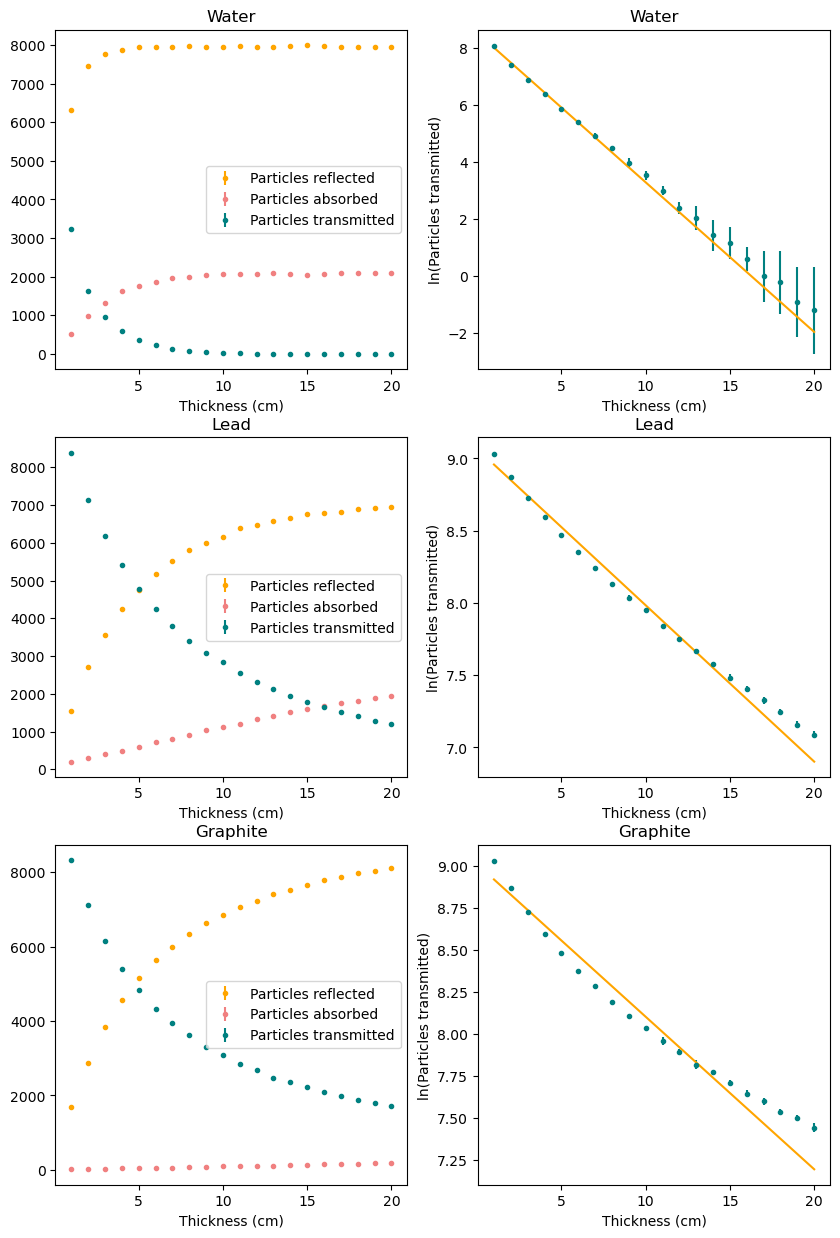

In [30]:
%matplotlib inline

#creating figures
fig = plt.figure(figsize = [10,15])
fig.tight_layout()
water_thickness_graph = fig.add_subplot(321)
water_thickness_loggraph = fig.add_subplot(322)
lead_thickness_graph = fig.add_subplot(323)
lead_thickness_loggraph = fig.add_subplot(324)
graphite_thickness_graph = fig.add_subplot(325)
graphite_thickness_loggraph = fig.add_subplot(326)

#creating an array of thicknesses
thicknesses_array = np.linspace(1, 20, 20)

def varying_thickness(number_of_runs, number_of_particles, mean_free_path, absorption_probability):
    """
    Uses the 'many_random_walk_statistics()' function to find the mean number of neutrons reflected, absorbed, and transmitted
    through a range of thicknesses of a given material, and the associated error on these values. The range of thicknesses is
    given by the global variable 'thicknesses_array'.
    
    Parameters
    ----------
    number_of_runs : int
        Represents the number of times the random walks should be generated.
    number_of_particles: int
        Represents the number of random walks to be generated.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    stats :  array
        An array of values displaying: the mean number of particles reflected, the error on the particles reflected, the mean
        number of particles absorbed, the error on the particles absorbed, the mean number of particles transmitted, and the
        error on the particles transmitted. Shows these values for every given thickness in 'thicknesses_array'.
    """
    
    stats = np.zeros((len(thicknesses_array), 6))
    
    for i in range(len(thicknesses_array)):
        stats[i, :] = many_random_walk_statistics(number_of_runs, number_of_particles, thicknesses_array[i], mean_free_path,
                                                  absorption_probability)
        
    return stats

def plotting_results(material_name, plot_names, number_of_runs, number_of_particles, mean_free_path, absorption_probability):
    """
    Finds the mean number of particles reflected, the error on the particles reflected, the mean number of particles absorbed, 
    the error on the particles absorbed, the mean number of particles transmitted, and the error on the particles transmitted
    from the 'varying_thickness()' function. Plots the variation of these values with thickness. Performs a linear fit of
    ln(mean number of particles transmitted) with thickness, and plots the corresponding line of best fit as well. Finds the
    attenuation length of the material (as well as its corresponding error) from the gradient of the line of best fit, and 
    prints this result.
    
    Parameters
    ----------
    material_name : string
        The name of the material from which the slab is made.
    plot_names : array
        An array of the subplots for which the data should be plotted.
    number_of_runs : int
        Represents the number of times the random walks should be generated.
    number_of_particles: int
        Represents the number of random walks to be generated.
    mean_free_path : float
        Represents the mean free path of the given material.
    absorption_probability : float
        Represents the probability that the particle will be absorbed, upon contact with a molecule of the given material.
        
    Returns
    -------
    fit :  array
        An array of values showing the gradient and intercept of the line of best fit.
    cov : array
        The covariance matrix of the line of best fit. The top left value in the matrix is the variance of the gradient, and 
        the bottom right value is the variance of the standard deviation.
    """
    #generating data from 'varying_thickness()' function
    stats = varying_thickness(number_of_runs, number_of_particles, mean_free_path, absorption_probability)
    
    #plotting the variation of each output of 'stats' with the thickness of the slab
    plot_names[0].errorbar(thicknesses_array, stats[:, 0], stats[:, 1], fmt = '.', label = 'Particles reflected',
                           color = 'orange')
    plot_names[0].errorbar(thicknesses_array, stats[:, 2], stats[:, 3], fmt = '.', label = 'Particles absorbed',
                           color = 'lightcoral')
    plot_names[0].errorbar(thicknesses_array, stats[:, 4], stats[:, 5], fmt = '.', label = 'Particles transmitted',
                           color = 'teal')
    plot_names[0].set_title(material_name)
    plot_names[0].set_xlabel('Thickness (cm)')
    plot_names[0].legend()
    
    #finding the line of best fit of ln(mean_transmitted) against thickness
    fit, cov = np.polyfit(thicknesses_array, np.log(stats[:, 4]), 1, w = (1 / stats[:, 5]), cov = True)
    
    #plotting the line of best fit
    plot_names[1].errorbar(thicknesses_array, np.log(stats[:, 4]), (stats[:, 5]), fmt = '.', color = 'teal')
    plot_names[1].plot(thicknesses_array, linear_function(thicknesses_array, fit[0], fit[1]), color = 'orange')
    plot_names[1].set_xlabel('Thickness (cm)')
    plot_names[1].set_ylabel('ln(Particles transmitted)')
    plot_names[1].set_title(material_name)
    
    #printing the attenuation length of the given material
    print('The attenuation length of {0} is ({1:.3f} \u00B1 {2:.3f}) cm'.format(material_name, (-1 / fit[0]), ((-1 / fit[0]) *\
        np.sqrt(cov[0, 0]))))
    
    return fit, cov


water_attenuation = plotting_results("Water", [water_thickness_graph, water_thickness_loggraph], 10, 10000,
                                     mean_free_path_water, absorption_probability_water)
lead_attenuation = plotting_results("Lead", [lead_thickness_graph, lead_thickness_loggraph], 10, 10000,
                                     mean_free_path_lead, absorption_probability_lead)
graphite_attenuation = plotting_results("Graphite", [graphite_thickness_graph, graphite_thickness_loggraph], 10, 10000,
                                     mean_free_path_graphite, absorption_probability_graphite)

plt.show()

It can be seen from this data that the transmission rate of each material decreases exponentially as thickness increases. However an exponential graph was not a good fit for the transmission rate of graphite. This may be because the macroscopic absorption cross-section is not necessarily constant as thickness increases, and it may vary with thickness for graphite (causing the data points to stray from an exponential fit). The errors on these values are again very small (it should be noted that error bars are present on all above data points, but some are too small to see). This is likely because the errors are an underestimate, for the same reasons as mentioned previously. Water has the lowest attenuation length, which was expected based on the high particle density.

## Woodcock method

Finally, we use the Woodcock method to predict the number of neutrons reflected, absorbed, and transmitted through two thicknesses of material. We have assumed that there is zero gap between the slabs of material. We run this simulation for 10000 particles 10 times in order to obtain average rates of reflection, absorption, and scattering.

The Woodcock method involves fictitious tracking of each particle in the slabs in order to accurately estimate the transmission rate through both slabs. The mean free path is calculated from the majorant cross-section of both materials. However, when the neutrons are in the material with the longer mean free path, the steps taken by the neutron are too short. In order to amend this, we say the neutron takes fictitious steps, in which the neutron collides with a nucleus and does nothing, continuing in the direction it was travelling previously. The probability that a particle takes a fictitious step is completely random. This method allows us to accurately simulate the true random walk of each neutron, without worrying about which slab the neutron is located (as that would be complex and inefficient to implement). We implement the Woodcock method here through 10cm slabs of lead & water, graphite & water, and lead & graphite.

----------------------------------------------------------------------
Transmission Through Two Materials Using Woodcock Method: Lead/Water
----------------------------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 6811 ± 0
Neutrons Absorbed = 3165 ± 0
Neutrons Transmitted = 22 ± 0
Percentage Transmitted = (0.227 ± 0.001) %
----------------------------------------------------------------------
Transmission Through Two Materials Using Woodcock Method: Graphite/Water
----------------------------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 7998 ± 0
Neutrons Absorbed = 1976 ± 0
Neutrons Transmitted = 25 ± 0
Percentage Transmitted = (0.253 ± 0.002) %
----------------------------------------------------------------------
Transmission Through Two Materials Using Woodcock Method: Lead/Graphite
----------------------------------------------------------------------
Total Neutrons = 10000
Neutrons Reflected = 7080 ±

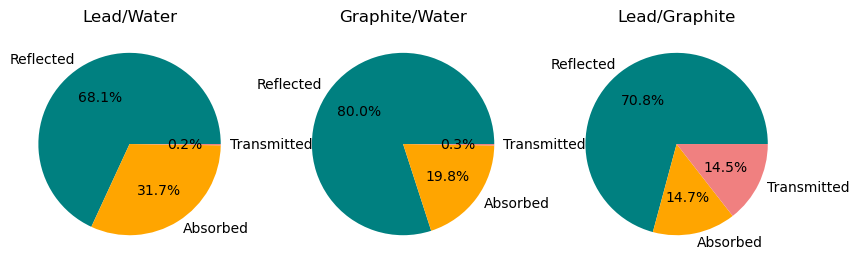

In [31]:
%matplotlib inline

#finding the sum of macroscopic absorption and scattering cross-sections for each material
total_macroscopic_coeff_water = macroscopic_absorption_coeff_water + macroscopic_scattering_coeff_water
total_macroscopic_coeff_lead = macroscopic_absorption_coeff_lead + macroscopic_scattering_coeff_lead
total_macroscopic_coeff_graphite = macroscopic_absorption_coeff_graphite + macroscopic_scattering_coeff_graphite

#creating figures
fig = plt.figure(figsize = [10, 6])
lead_water_graph = fig.add_subplot(131)
graphite_water_graph = fig.add_subplot(132)
lead_graphite_graph = fig.add_subplot(133)        

def woodcock_method_statistics(number_of_particles, thicknesses, total_macroscopic_coeffs, absorption_probabilities):
    """
    Generates a random walk for a set number of particles through two thicknesses of material using the Woodcock method.
    It is assumed that these materials are stuck together with no gap between them. Returns the number of particles reflected
    back from the first material, absorbed into one of the materials, or transmitted through both materials.
    
    Parameters
    ----------
    number_of_particles : int
        Represents the number of random walks to be generated.
    thicknesses : array
        An array displaying the respective thicknesses of each slab of material.
    total_macroscopic_coeffs : array
        An array displaying the total macroscopic cross-sections of each material.
    absorption_probabilities : array
        An array displaying the respective absorption probabilities of each material.
        
    Returns
    -------
    particles_reflected :  int
        Represents the total number of particles reflected back out from the first material.
    particles_absorbed :  int
        Represents the total number of particles absorbed into one of the materials.
    particles_transmitted :  int
        Represents the total number of particles transmitted out of the second material.
    """
    number_reflected = 0
    number_absorbed = 0
    number_transmitted = 0
    
    #finding the majorant cross section and the mean free path through the thicknesses
    majorant_cross_section = max(total_macroscopic_coeffs[0], total_macroscopic_coeffs[1])
    mean_free_path = 1 / majorant_cross_section
    
    #setting arrays of each particle's initial x-coordinate, polar angle, and azimuthal angle
    x_coordinate = -1 * mean_free_path * np.log(np.random.uniform(size = number_of_particles))
    theta = np.full(number_of_particles, (np.pi / 2))
    phi = np.zeros(number_of_particles)

    #starting the random walk
    while(len(x_coordinate) > 0):
        #setting an array which will contain the arguments of the particles absorbed, reflected, or transmitted
        coordinates_to_delete = []
        
        #finding the number (and arguments) of the reflected particles
        number_reflected += np.count_nonzero(x_coordinate < 0)
        reflected_positions = np.where(x_coordinate < 0)

        #finding the number (and arguments) of the transmitted particles
        number_transmitted += np.count_nonzero(x_coordinate > (thicknesses[0] + thicknesses[1]))
        transmitted_positions = np.where(x_coordinate > (thicknesses[0] + thicknesses[1]))
        
        #finding the number of particles within each slab
        particles_in_first_slab = np.count_nonzero(x_coordinate < thicknesses[0])
        particles_in_second_slab = np.count_nonzero(np.logical_and(x_coordinate > thicknesses[0],
                                                    x_coordinate < (thicknesses[0] + thicknesses[1])))
        
        #creating an array of boolean values and finding which of the particles have taken a fictitious step
        #each particle which took a fictitious step will have a value of 'True' in the boolean array
        fictitious = np.full(len(x_coordinate), False)
        fictitious_random_number = np.random.uniform(size = len(x_coordinate))
        
        #finding the particles that took a fictitious step in the first material
        fictitious[np.argwhere(np.logical_and(fictitious_random_number > (total_macroscopic_coeffs[0] /\
                majorant_cross_section), x_coordinate < thicknesses[0]))] = True
        
        #finding the particles that took a fictitious step in the second material
        fictitious[np.argwhere(np.logical_and(fictitious_random_number > (total_macroscopic_coeffs[1] /\
                    majorant_cross_section), x_coordinate > thicknesses[0],
                    x_coordinate < (thicknesses[0] + thicknesses[1])))] = True  
        
        #calculating the number of real and fictitious steps
        number_of_fictitious_steps = fictitious.sum()
        number_of_real_steps = len(fictitious) - number_of_fictitious_steps
        
        #each particle that took a fictitious step will take another step in the same direction it took previously
        #note: the length of this step is given by exp(-x / lambda) as before
        x_coordinate[fictitious == 1] += -1 * mean_free_path * np.log(np.random.uniform(size = number_of_fictitious_steps)) * \
                                        np.sin(theta[fictitious == 1]) * np.cos(phi[fictitious == 1])
        
        
        absorbed_random_number = np.random.uniform(size = len(x_coordinate))
        
        #finding the number of particles absorbed in the first slab
        number_absorbed += np.count_nonzero(np.logical_and(np.logical_and(fictitious == 0, x_coordinate < thicknesses[0]), 
                            np.logical_and(x_coordinate > 0, absorbed_random_number < absorption_probabilities[0])))
        
        #finding the number of particles absorbed in the second slab
        number_absorbed += np.count_nonzero(np.logical_and(np.logical_and(fictitious == 0, x_coordinate > thicknesses[0]),
                         np.logical_and(x_coordinate < (thicknesses[0] + thicknesses[1]),
                                        absorbed_random_number < absorption_probabilities[1])))
                                                    
        #finding the locations of the particles absorbed (in the first and second slab) within the x_coordinate array
        absorbed_positions = np.where(np.logical_and(np.logical_and(fictitious == 0, x_coordinate < thicknesses[0]), 
                                        np.logical_and(x_coordinate > 0, absorbed_random_number < absorption_probabilities[0])))
        absorbed_positions_2 = np.where(np.logical_and(np.logical_and(fictitious == 0, x_coordinate > thicknesses[0]),
                                        np.logical_and(x_coordinate < (thicknesses[0] + thicknesses[1]),
                                                            absorbed_random_number < absorption_probabilities[1])))
        
    
        #removing particles which have been reflected, absorbed, or transmitted
        coordinates_to_delete = np.hstack((reflected_positions, transmitted_positions, absorbed_positions,
                                           absorbed_positions_2))
        
        x_coordinate = np.delete(x_coordinate, coordinates_to_delete)
        theta = np.delete(theta, coordinates_to_delete)
        phi = np.delete(phi, coordinates_to_delete)
        fictitious = np.delete(fictitious, coordinates_to_delete)
        number_of_fictitious_steps = fictitious.sum()
        
        #finding the number of particles which were scattered within the slabs, and did not take a fictitious step
        number_of_real_steps = len(x_coordinate) - number_of_fictitious_steps
        
        #adding an isotropic step to the x-coordinate of each of the particles that satisfied the above conditions
        new_step = isotropic_steps(mean_free_path, number_of_real_steps)
        
        #updating the x-coordinates and directions of each particle
        x_coordinate[fictitious == 0] += new_step[0]
        theta[fictitious == 0] += new_step[4]
        phi[fictitious == 0] += new_step[5]

        
    return number_reflected, number_absorbed, number_transmitted
                                                    
def woodcock_data(number_of_runs, number_of_particles, thicknesses, total_macroscopic_coeffs, absorption_probabilities):
    """
    Repeats the woodcock method for a set number of particles many times using a thread pool. Finds the mean particles absorbed,
    transmitted, and reflected, as well as the standard deviation of these values. Returns the mean number of particles 
    reflected, absorbed, and transmitted, and the associated error on these.
    
    Parameters
    ----------
    number_of_runs : int
        Represents the number of times the set of random walks should be generated.
    number_of_particles: int
        Represents the number of random walks to be generated.
    thicknesses : array
        An array displaying the respective thicknesses of each slab of material.
    total_macroscopic_coeffs : array
        An array displaying the total macroscopic cross-sections of each material.
    absorption_probabilities : array
        An array displaying the respective absorption probabilities of each material.
        
    Returns
    -------
    mean_reflected :  float
        Represents the mean number of particles reflected back out from the first material.
    reflected_error : float
        Represents the error on the number of reflected particles.
    mean_absorbed :  float
        Represents the mean number of particles absorbed into one of the materials.
    absorbed_error : float
        Represents the error on the number of absorbed particles.
    mean_transmitted :  float
        Represents the mean number of particles transmitted out of the slabs of material.
    transmitted_error : float
        Represents the error on the number of transmitted particles.
    """
    #generates sets of random walks using a thread pool
    with concurrent.futures.ThreadPoolExecutor() as executor:
        data = [executor.submit(woodcock_method_statistics, number_of_particles, thicknesses, total_macroscopic_coeffs, 
                absorption_probabilities) for i in range(number_of_runs)]
        
    total_reflected = 0
    total_absorbed = 0
    total_transmitted = 0

    #finding the total number of particles reflected, absorbed, and transmitted from each data set
    random_walks_statistics = np.array([i.result() for i in data])
    reflected = random_walks_statistics[:,0]
    absorbed = random_walks_statistics[:,1]
    transmitted = random_walks_statistics[:,2]
    
    #finding the mean and error on these values    
    mean_reflected = np.mean(reflected)
    reflected_error = np.std(reflected) / mean_reflected
    mean_absorbed = np.mean(absorbed)
    absorbed_error = np.std(absorbed) / mean_absorbed
    mean_transmitted = np.mean(transmitted)
    transmitted_error = np.std(transmitted) / mean_transmitted
    
    return mean_reflected, reflected_error, mean_absorbed, absorbed_error, mean_transmitted, transmitted_error

def produce_results_woodcock(material_names, graph_name, number_of_runs, number_of_particles, thicknesses,
                             total_macroscopic_coeffs, absorption_probabilities):
    """
    Uses the 'woodcock_data()' function to find the mean number of neutrons reflected, absorbed, and transmitted
    through set thicknesses of two given materials, and the associated error on these values. Produces a results statement 
    displaying this data.
    
    Parameters
    ----------
    material_names : string
        The name of the materials from which the slabs are made.
    graph_name : matplotlib.axes._subplots.AxesSubplot
        The subplot where the data should be plotted.
    number_of_runs : int
        Represents the number of times the random walks should be generated.
    number_of_particles: int
        Represents the number of random walks to be generated.
    thicknesses : array
        An array displaying the respective thicknesses of each slab of material.
    total_macroscopic_coeffs : array
        An array displaying the total macroscopic cross-sections of each material.
    absorption_probabilities : array
        An array displaying the respective absorption probabilities of each material.
    """
    global particles_reflected, particles_absorbed, particles_transmitted
    particles_reflected = 0
    particles_absorbed = 0
    particles_transmitted = 0
    
    #obtaining the data from the 'woodcock_data()' function
    rates = woodcock_data(number_of_runs, number_of_particles, thicknesses, total_macroscopic_coeffs, absorption_probabilities)
    
    print('----------------------------------------------------------------------')
    print("Transmission Through Two Materials Using Woodcock Method: {0}".format(material_names))
    print('----------------------------------------------------------------------')
    print("Total Neutrons = {0}".format((number_of_particles)))
    print("Neutrons Reflected = {0} \u00B1 {1}".format(int(rates[0]), round(rates[1])))
    print("Neutrons Absorbed = {0} \u00B1 {1}".format(int(rates[2] ), round(rates[3])))
    print("Neutrons Transmitted = {0} \u00B1 {1}".format(int(rates[4]), round(rates[5])))
    print("Percentage Transmitted = ({0:.3f} \u00B1 {1:.3f}) %".format((rates[4] / 100), (rates[5] / 100)))
    
    #plotting the number of particles reflected, absorbed, and transmitted in a pie chart
    graph_name.pie((rates[0], rates[2], rates[4]), labels = ('Reflected', 'Absorbed', 'Transmitted'), autopct='%1.1f%%',
                  colors = ['teal', 'orange', 'lightcoral'])
    graph_name.set_title(material_names)
    
    return None

#producing results for 10 cm slabs of lead & water, graphite & water, and lead & graphite
lead_water = produce_results_woodcock('Lead/Water', lead_water_graph, 10, 10000, [10, 10], [total_macroscopic_coeff_lead,
            total_macroscopic_coeff_water], [absorption_probability_lead, absorption_probability_water])

graphite_water = produce_results_woodcock('Graphite/Water', graphite_water_graph, 10, 10000, [10, 10],
                [total_macroscopic_coeff_graphite, total_macroscopic_coeff_water], [absorption_probability_graphite, 
                absorption_probability_water])

lead_graphite = produce_results_woodcock('Lead/Graphite', lead_graphite_graph, 10, 10000, [10, 10],
                [total_macroscopic_coeff_lead, total_macroscopic_coeff_graphite], [absorption_probability_lead, 
                absorption_probability_graphite])
plt.show()

## Summary

In conclusion, the Monte Carlo technique is a powerful tool used to accurately simulate random events such as neutron scattering. By generating true randomly distributed numbers, it was possible to obtain accurate reflection, absorption, and transmission rates of neutrons travelling through set thicknesses of different materials. The transmission rate of neutrons was found to decay exponentially as the thickness of material increased. This is because the probability of each neutron being absorbed increased as the number of collisions increased, reducing the probability of each neutron passing through the material without being absorbed or scattered.

It should be noted that assumptions had been made about the system that may have affected the uncertainty in our final results. For example, the fluctuation in density (and presence of any impurities) of each material was ignored in order to simplify the system. This led to our final uncertainties being underestimates; accounting for these assumptions likely would have improved the accuracy of our final results. However, throughout this project the Monte Carlo method has been shown to effectively model complex systems of many neutrons, and obtain accurate predictions for the transmission rates of each material.